# Build a Sugeno inference system

This tutorial describes how to construct a type-1 Sugeno inference system.
The reader is assumed to be familiar with the basic syntax to build a fuzzy system, which
is described in the Build a Mamdani inference system tutorial.

DOWNLOAD_NOTE

A Sugeno inference system can be built using the `@sugfis` macro.
The following example shows the macro in action

In [1]:
using FuzzyLogic, Plots

fis = @sugfis function tipper(service, food)::tip
    service := begin
        domain = 0:10
        poor = GaussianMF(0.0, 1.5)
        good = GaussianMF(5.0, 1.5)
        excellent = GaussianMF(10.0, 1.5)
    end

    food := begin
        domain = 0:10
        rancid = TrapezoidalMF(-2, 0, 1, 3)
        delicious = TrapezoidalMF(7, 9, 10, 12)
    end

    tip := begin
        domain = 0:30
        cheap = 5.002
        average = 15
        generous = 2service, 0.5food, 5.0
    end

    service == poor || food == rancid --> tip == cheap
    service == good --> tip == average
    service == excellent || food == delicious --> tip == generous
end

tipper

Inputs:
-------
service ∈ [0, 10] with membership functions:
    poor = GaussianMF(0.0, 1.5)
    good = GaussianMF(5.0, 1.5)
    excellent = GaussianMF(10.0, 1.5)

food ∈ [0, 10] with membership functions:
    rancid = TrapezoidalMF(-2, 0, 1, 3)
    delicious = TrapezoidalMF(7, 9, 10, 12)


Outputs:
--------
tip ∈ [0, 30] with membership functions:
    cheap = 5.002
    average = 15
    generous = 2.0service + 0.5food + 5.0


Inference rules:
----------------
(service is poor ∨ food is rancid) --> tip is cheap
service is good --> tip is average
(service is excellent ∨ food is delicious) --> tip is generous


Settings:
---------
- ProdAnd()
- ProbSumOr()


The result is an object of type `SugenoFuzzySystem`. This is similar to a Mamdani, with the main difference being in
the output definition.
In a Sugeno system, the output "membership functions" can be:

- A `ConstantSugenoOutput`, e.g. `average = 15`. This means that if the tip is average, then it has constant value $15$,
- A `LinearSugenoOutput`, e.g. `generous = 2service, 0.5food, 5.0`. This means that if the tip is generous, then its value will be $2service+0.5food + 5.0$.

It is good to highlight that these functions return the value of the output variable and not a membership degree, like in a Mamdani system.

The second difference from a Mandani system is in the settings that can be tuned. A Sugeno system only has the following options:

- `and`: algorithm to evaluate `&&`. Must be one of the available Conjuction methods. Default `ProdAnd`.
- `or`: algorithm to evaluate `||`. Must be one of the available Disjunction methods. Default `ProbSumOr`

The created model can be evaluated the same way of a Mamdani system.

In [2]:
fis(service = 2, food = 3)

1-element Dictionaries.Dictionary{Symbol, Union{Float64, FuzzyLogic.Interval{Float64}}}
 :tip │ 7.4781463658605665

Let's see the plotting of output variables, as it differs from the Mamdani system

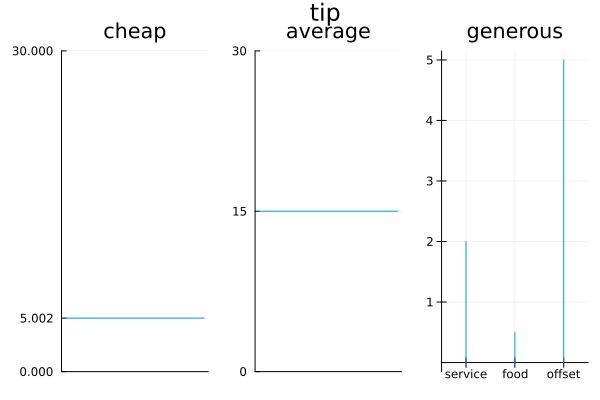

In [3]:
plot(fis, :tip)

As you can see

- If the membership function is constant, then the plot simply shows a horizontal line at the output value level.
- For `LinearSugenoOutput`, the plot is a bar plot, showing for each input variable the corresponding coefficient.
  This gives a visual indication of how much each input contributes to the output.

Like the Mamdani case, we can plot the whole system.

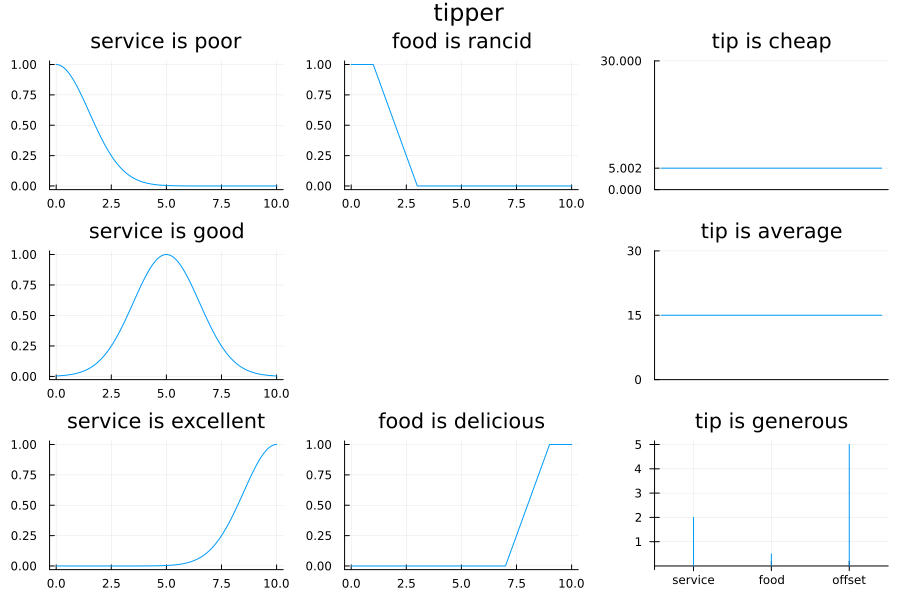

In [4]:
plot(fis)

Similarly to Mamdani, we can also generate stand-alone Julia code

In [5]:
fis_ex = compilefis(fis)

:(function tipper(service, food)
      poor = exp(-((service - 0.0) ^ 2) / 4.5)
      good = exp(-((service - 5.0) ^ 2) / 4.5)
      excellent = exp(-((service - 10.0) ^ 2) / 4.5)
      rancid = max(min((food - -2) / 2, 1, (3 - food) / 2), 0)
      delicious = max(min((food - 7) / 2, 1, (12 - food) / 2), 0)
      ant1 = (poor + rancid) - poor * rancid
      ant2 = good
      ant3 = (excellent + delicious) - excellent * delicious
      tot_weight = ant1 + ant2 + ant3
      cheap = 5.002
      average = 15
      generous = 5.0 + 2.0service + 0.5 * food
      tip = (ant1 * cheap + ant2 * average + ant3 * generous) / tot_weight
      return tip
  end)

In [6]:
eval(fis_ex)
tipper(2, 3)

7.4781463658605665